Image classification with CNNs
================

The goal of this exercise is to implement a specific CNN architecture with PyTorch and train it on the CIFAR-10 image classification dataset. We will start by introducing the dataset and then implement a `nn.Module` and a useful `Solver` class. Seperating the model from the actual training has proven itself as a sensible design decision. By the end of this exercise you should have succesfully trained your (possible) first CNN model and have a boilerplate `Solver` class which you can reuse for the next exercise and your future research projects.

For an inspiration on how to implement a model or the solver class you can have a look at [these](https://github.com/pytorch/examples) PyTorch examples.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

#from dl4cv.classifiers.classification_cnn import ClassificationCNN
from yz.data_utils import get_Cancer_datasets
#torch.set_default_tensor_type('torch.FloatTensor')

csv_full_name = '/home/hpc/pr92no/ga42cih2/Projects/dl4cvproject/data/train.csv'
img_folder_full_name = '/home/hpc/pr92no/ga42cih2/Projects/dl4cvproject/data/train_256'

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cancer Dataset
=========

Since the focus of this exercise should be neural network models and how to successfully train them, we provide you with preprocessed and prepared datasets. For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the `Dataset` classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the `Dataset` classes. See `torchvision.Transform` for examples.</p>
</div>

In [44]:
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.

train_data, val_data, test_data, train_label_list = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name)
#train_data, val_data, test_data, train_label_list = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name,
#                                                                                  num_training=50, num_validation=20, num_test=30)
# X = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name, num_training=800, num_validation=100, num_test=100)
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

100%|█████████▉| 18547/18577 [01:03<00:00, 291.05it/s]

transforming...
X.shape:(18577, 256, 256, 3)
X_original.shape:(18577, 256, 256)
mean:125.83685163263934



100%|██████████| 18577/18577 [00:00<00:00, 1641856.53it/s]

std:63.15855322359238
Done transforming...
Getting labels
submasking...
num_training:16000
OK...
Train size: 16000
Val size: 1250
Test size: 1327


100%|█████████▉| 18547/18577 [01:20<00:00, 231.61it/s]

In [45]:
#print(len(train_data))
print(type(train_data), type(val_data), type(test_data))
print()
for i in range(1):
    inputs, labels = train_data[i]
    print('label_type: {}'.format(type(labels)))

img, lb = train_data[i]
print('img_type: {}'.format(type(img)))
print('img_shape:{}'.format(img.size()))

<class 'yz.data_utils.CancerData'> <class 'yz.data_utils.CancerData'> <class 'yz.data_utils.CancerData'>

label_type: <class 'numpy.int64'>
img_type: <class 'torch.FloatTensor'>
img_shape:torch.Size([3, 224, 224])


In [47]:
from tqdm import tqdm
label_set = set()
cnt = [0] * 14
for i in tqdm(range(len(train_data))):
    _, labels = train_data[i]
    for num in range(len(cnt)):
        if labels == num:
            cnt[num] += 1
    label_set.add(labels)
print(label_set)
print(cnt)

100%|██████████| 16000/16000 [00:27<00:00, 591.51it/s]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
[373, 575, 4929, 1083, 2039, 1138, 2152, 338, 57, 170, 681, 1421, 585, 459]


In [48]:
# find a sample with certain index

class_label = 13
for i in range(len(train_data)):
    _, labels = train_data[i]
    if labels == class_label:
        print(i)
        break

68


Visualize Examples
------------------

To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

128199

( 0 ,.,.) = 
 -1.5435 -1.4965 -1.4024  ...  -1.8259 -1.8259 -1.8416
 -1.3553 -1.3082 -1.3082  ...  -1.6847 -1.7161 -1.7631
 -1.2298 -1.2298 -1.2298  ...  -1.5906 -1.6220 -1.6690
           ...             ⋱             ...          
  0.9192  1.1231  1.1545  ...  -1.9200 -1.9200 -1.9200
  0.9192  1.1545  1.1702  ...  -1.9200 -1.9200 -1.9200
  0.9506  1.1859  1.1859  ...  -1.9200 -1.9200 -1.9200

( 1 ,.,.) = 
 -1.5435 -1.4965 -1.4024  ...  -1.8259 -1.8259 -1.8416
 -1.3553 -1.3082 -1.3082  ...  -1.6847 -1.7161 -1.7631
 -1.2298 -1.2298 -1.2298  ...  -1.5906 -1.6220 -1.6690
           ...             ⋱             ...          
  0.9192  1.1231  1.1545  ...  -1.9200 -1.9200 -1.9200
  0.9192  1.1545  1.1702  ...  -1.9200 -1.9200 -1.9200
  0.9506  1.1859  1.1859  ...  -1.9200 -1.9200 -1.9200

( 2 ,.,.) = 
 -1.5435 -1.4965 -1.4024  ...  -1.8259 -1.8259 -1.8416
 -1.3553 -1.3082 -1.3082  ...  -1.6847 -1.7161 -1.7631
 -1.2298 -1.2298 -1.2298  ...  -1.5906 -1.6220 -1.6690
           ...  

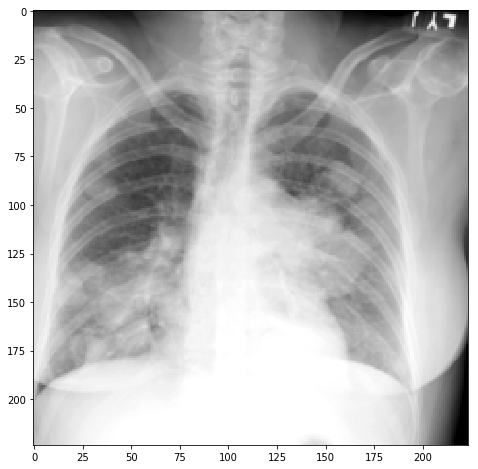

In [63]:

index = 10000
img, _ = train_data[index]
print(torch.sum(img > 0))
print(img)
to_plot = img.cpu().numpy() #+ mean_image
print(to_plot.shape)
plt.imshow(to_plot[0])
plt.show()

## Model Architecture and Forward Pass 

After you understood the core concepts of PyTorch and have a rough idea on how to implement your own model, complete the initialization and forward methods of the `ClassificationCNN` in the `dl4cv/classifiers/classification_cnn.py` file. Note that we do not have to implement a backward pass since this is automatically handled by the `autograd` package.

Use the cell below to check your results:

## Training and Validation with the Solver
We train and validate our previously generated model with a seperate `Solver` class defined in `dl4cv/solver.py`. Complete the `.train()` method and try to come up with an efficient iteration scheme as well as an informative training logger.

Use the cells below to test your solver. A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>As seen below, the design of our `Solver` class is indepdenent of the particular model or data pipeline. This facilitates the reuse of the class and its modular structure allows the training of different models.</p>
</div>

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

## Train the Network
Now train your model with the full dataset. By training a `ThreeLayerCNN` model for one epoch, you should already achieve greater than 40% accuracy on the validation set. If your training is painfully slow check if you did not forget to call the `nn.Module.cuda()` method.

For the overfitting example we provided you with a set of hyperparamters (`hidden_dim`, `lr`, `weight_decay`, ...). You can start with the same parameter values but in order to maximize your accuracy you should try to train multiple models with different sets of hyperparamters. This process is called hyperparameter optimization.

In [52]:
from yz.classifiers.classification_cnn import ClassificationCNN
from yz.classifiers.transferred_alexnet import alexnet
from yz.solver import Solver
from yz.data_utils import get_balanced_weights
from torchvision import models
import torch.nn as nn

weights = get_balanced_weights(train_label_list, 14)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=30, shuffle=False, sampler=sampler, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=30, shuffle=False, num_workers=8)

model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


model.classifier  = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 14),
)

#list(model.classifier.children())[:-1] = nn.Linear(4096, 14)  

solver = Solver()
solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=1)

weights: [11.834979956079948, 9.532087499751988, 3.2556861617307438, 6.9455671481458747, 5.0618973019830511, 6.7756476197571684, 4.9272070121054501, 12.432646702181056, 30.27502530434386, 17.530628316511322, 8.7588761741639694, 6.0635212465976114, 9.4502654925111216, 10.668800640213409]


  0%|          | 0/1 [00:00<?, ?it/s]

START TRAIN.



0it [00:00, ?it/s]
1it [00:17, 17.29s/it]

[Iteration 1 / 534] TRAIN loss: 2.663817



2it [00:34, 17.15s/it]

[Iteration 2 / 534] TRAIN loss: 2.623103



3it [00:51, 17.18s/it]

[Iteration 3 / 534] TRAIN loss: 2.589816



4it [01:08, 17.15s/it]

[Iteration 4 / 534] TRAIN loss: 2.647666



5it [01:25, 17.15s/it]

[Iteration 5 / 534] TRAIN loss: 2.643425



6it [01:43, 17.17s/it]

[Iteration 6 / 534] TRAIN loss: 2.675918



7it [02:00, 17.19s/it]

[Iteration 7 / 534] TRAIN loss: 2.646035



8it [02:16, 17.01s/it]

[Iteration 8 / 534] TRAIN loss: 2.609935



9it [02:31, 16.88s/it]

[Iteration 9 / 534] TRAIN loss: 2.642316



10it [02:47, 16.76s/it]

[Iteration 10 / 534] TRAIN loss: 2.616975



11it [03:03, 16.67s/it]

[Iteration 11 / 534] TRAIN loss: 2.694248



12it [03:19, 16.59s/it]

[Iteration 12 / 534] TRAIN loss: 2.653989



13it [03:34, 16.52s/it]

[Iteration 13 / 534] TRAIN loss: 2.664376



14it [03:50, 16.46s/it]

[Iteration 14 / 534] TRAIN loss: 2.710856



15it [04:07, 16.50s/it]

[Iteration 15 / 534] TRAIN loss: 2.688304



16it [04:23, 16.45s/it]

[Iteration 16 / 534] TRAIN loss: 2.695493



17it [04:38, 16.41s/it]

[Iteration 17 / 534] TRAIN loss: 2.643815



18it [04:54, 16.37s/it]

[Iteration 18 / 534] TRAIN loss: 2.663674



19it [05:10, 16.33s/it]

[Iteration 19 / 534] TRAIN loss: 2.629508



20it [05:26, 16.30s/it]

[Iteration 20 / 534] TRAIN loss: 2.641320



21it [05:41, 16.27s/it]

[Iteration 21 / 534] TRAIN loss: 2.648154



22it [05:57, 16.25s/it]

[Iteration 22 / 534] TRAIN loss: 2.629501



23it [06:13, 16.22s/it]

[Iteration 23 / 534] TRAIN loss: 2.636884



24it [06:28, 16.20s/it]

[Iteration 24 / 534] TRAIN loss: 2.668652



25it [06:44, 16.18s/it]

[Iteration 25 / 534] TRAIN loss: 2.626681



26it [07:00, 16.17s/it]

[Iteration 26 / 534] TRAIN loss: 2.663818



27it [07:16, 16.16s/it]

[Iteration 27 / 534] TRAIN loss: 2.628583



28it [07:31, 16.14s/it]

[Iteration 28 / 534] TRAIN loss: 2.662078



29it [07:47, 16.13s/it]

[Iteration 29 / 534] TRAIN loss: 2.615833



30it [08:03, 16.12s/it]

[Iteration 30 / 534] TRAIN loss: 2.661061



31it [08:19, 16.11s/it]

[Iteration 31 / 534] TRAIN loss: 2.677383



32it [08:35, 16.09s/it]

[Iteration 32 / 534] TRAIN loss: 2.623743



33it [08:50, 16.09s/it]

[Iteration 33 / 534] TRAIN loss: 2.639792



34it [09:06, 16.08s/it]

[Iteration 34 / 534] TRAIN loss: 2.642998



35it [09:22, 16.08s/it]

[Iteration 35 / 534] TRAIN loss: 2.633511



36it [09:38, 16.07s/it]

[Iteration 36 / 534] TRAIN loss: 2.646101



37it [09:54, 16.07s/it]

[Iteration 37 / 534] TRAIN loss: 2.597108



38it [10:10, 16.06s/it]

[Iteration 38 / 534] TRAIN loss: 2.650926



39it [10:26, 16.07s/it]

[Iteration 39 / 534] TRAIN loss: 2.633184



40it [10:42, 16.06s/it]

[Iteration 40 / 534] TRAIN loss: 2.601254



41it [10:58, 16.05s/it]

[Iteration 41 / 534] TRAIN loss: 2.674067



42it [11:13, 16.05s/it]

[Iteration 42 / 534] TRAIN loss: 2.668201



43it [11:29, 16.04s/it]

[Iteration 43 / 534] TRAIN loss: 2.672994



44it [11:45, 16.03s/it]

[Iteration 44 / 534] TRAIN loss: 2.647642



45it [12:01, 16.03s/it]

[Iteration 45 / 534] TRAIN loss: 2.707227



46it [12:17, 16.02s/it]

[Iteration 46 / 534] TRAIN loss: 2.633572



47it [12:32, 16.02s/it]

[Iteration 47 / 534] TRAIN loss: 2.613049



48it [12:48, 16.01s/it]

[Iteration 48 / 534] TRAIN loss: 2.627809



49it [13:04, 16.01s/it]

[Iteration 49 / 534] TRAIN loss: 2.643590



50it [13:20, 16.00s/it]

[Iteration 50 / 534] TRAIN loss: 2.653482



51it [13:35, 16.00s/it]

[Iteration 51 / 534] TRAIN loss: 2.676354



52it [13:51, 15.99s/it]

[Iteration 52 / 534] TRAIN loss: 2.655237



53it [14:07, 15.98s/it]

[Iteration 53 / 534] TRAIN loss: 2.645160



54it [14:23, 15.98s/it]

[Iteration 54 / 534] TRAIN loss: 2.620140



55it [14:38, 15.98s/it]

[Iteration 55 / 534] TRAIN loss: 2.633839



56it [14:54, 15.97s/it]

[Iteration 56 / 534] TRAIN loss: 2.670941


Process Process-66:
Process Process-70:
Process Process-68:
Process Process-65:
Process Process-72:
Process Process-71:
Process Process-67:
Process Process-69:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hpc/pr92no/ga42cih2/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hpc/pr92no/ga42cih2/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hpc/pr92no/ga42cih2/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hpc/pr92no/ga42cih2/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hpc/pr92no/ga42cih2/anaconda3/lib/python3.

KeyboardInterrupt: 

In [ ]:
solver = Solver()
solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=1)


  0%|          | 0/1 [00:00<?, ?it/s]

START TRAIN.




0it [00:00, ?it/s]

1it [00:17, 17.80s/it]

[Iteration 1 / 534] TRAIN loss: 2.644462




2it [00:35, 17.51s/it]

[Iteration 2 / 534] TRAIN loss: 2.673614




3it [00:52, 17.36s/it]

[Iteration 3 / 534] TRAIN loss: 2.641987




4it [01:09, 17.32s/it]

[Iteration 4 / 534] TRAIN loss: 2.667780




5it [01:26, 17.29s/it]

[Iteration 5 / 534] TRAIN loss: 2.636185




6it [01:43, 17.29s/it]

[Iteration 6 / 534] TRAIN loss: 2.648556




7it [02:00, 17.26s/it]

[Iteration 7 / 534] TRAIN loss: 2.633703




8it [02:17, 17.25s/it]

[Iteration 8 / 534] TRAIN loss: 2.634700




9it [02:35, 17.24s/it]

[Iteration 9 / 534] TRAIN loss: 2.630407




10it [02:52, 17.24s/it]

[Iteration 10 / 534] TRAIN loss: 2.658866




11it [03:09, 17.24s/it]

[Iteration 11 / 534] TRAIN loss: 2.668520




12it [03:26, 17.24s/it]

[Iteration 12 / 534] TRAIN loss: 2.706485




13it [03:44, 17.23s/it]

[Iteration 13 / 534] TRAIN loss: 2.638510




14it [04:01, 17.23s/it]

[Iteration 14 / 534] TRAIN loss: 2.660055




15it [04:18, 17.23s/it]

[Iteration 15 / 534] TRAIN loss: 2.637770




16it [04:35, 17.23s/it]

[Iteration 16 / 534] TRAIN loss: 2.629227




17it [04:52, 17.22s/it]

[Iteration 17 / 534] TRAIN loss: 2.653086




18it [05:09, 17.22s/it]

[Iteration 18 / 534] TRAIN loss: 2.618524




19it [05:27, 17.22s/it]

[Iteration 19 / 534] TRAIN loss: 2.610296




20it [05:44, 17.22s/it]

[Iteration 20 / 534] TRAIN loss: 2.628582




21it [06:01, 17.22s/it]

[Iteration 21 / 534] TRAIN loss: 2.635428




22it [06:18, 17.21s/it]

[Iteration 22 / 534] TRAIN loss: 2.652800




23it [06:35, 17.21s/it]

[Iteration 23 / 534] TRAIN loss: 2.643928




24it [06:53, 17.21s/it]

[Iteration 24 / 534] TRAIN loss: 2.619779




25it [07:10, 17.21s/it]

[Iteration 25 / 534] TRAIN loss: 2.607081




26it [07:27, 17.21s/it]

[Iteration 26 / 534] TRAIN loss: 2.671219




27it [07:44, 17.21s/it]

[Iteration 27 / 534] TRAIN loss: 2.605569




28it [08:01, 17.21s/it]

[Iteration 28 / 534] TRAIN loss: 2.638737




29it [08:19, 17.21s/it]

[Iteration 29 / 534] TRAIN loss: 2.643098




30it [08:36, 17.21s/it]

[Iteration 30 / 534] TRAIN loss: 2.633116




31it [08:53, 17.21s/it]

[Iteration 31 / 534] TRAIN loss: 2.600591




32it [09:10, 17.21s/it]

[Iteration 32 / 534] TRAIN loss: 2.649443




33it [09:28, 17.21s/it]

[Iteration 33 / 534] TRAIN loss: 2.676280




34it [09:45, 17.21s/it]

[Iteration 34 / 534] TRAIN loss: 2.673797




35it [10:02, 17.21s/it]

[Iteration 35 / 534] TRAIN loss: 2.628770




36it [10:19, 17.21s/it]

[Iteration 36 / 534] TRAIN loss: 2.612122




37it [10:36, 17.21s/it]

[Iteration 37 / 534] TRAIN loss: 2.630881




38it [10:54, 17.21s/it]

[Iteration 38 / 534] TRAIN loss: 2.620207




39it [11:11, 17.22s/it]

[Iteration 39 / 534] TRAIN loss: 2.676785




40it [11:28, 17.22s/it]

[Iteration 40 / 534] TRAIN loss: 2.651951




41it [11:45, 17.22s/it]

[Iteration 41 / 534] TRAIN loss: 2.656278




42it [12:02, 17.21s/it]

[Iteration 42 / 534] TRAIN loss: 2.659115




43it [12:20, 17.21s/it]

[Iteration 43 / 534] TRAIN loss: 2.617619




44it [12:36, 17.20s/it]

[Iteration 44 / 534] TRAIN loss: 2.622153




45it [12:52, 17.17s/it]

[Iteration 45 / 534] TRAIN loss: 2.637049




46it [13:08, 17.14s/it]

[Iteration 46 / 534] TRAIN loss: 2.565621




47it [13:24, 17.12s/it]

[Iteration 47 / 534] TRAIN loss: 2.630591




48it [13:40, 17.09s/it]

[Iteration 48 / 534] TRAIN loss: 2.650403




49it [13:56, 17.07s/it]

[Iteration 49 / 534] TRAIN loss: 2.659628




50it [14:12, 17.04s/it]

[Iteration 50 / 534] TRAIN loss: 2.619627




51it [14:27, 17.02s/it]

[Iteration 51 / 534] TRAIN loss: 2.663224




52it [14:43, 16.99s/it]

[Iteration 52 / 534] TRAIN loss: 2.606656




53it [14:59, 16.97s/it]

[Iteration 53 / 534] TRAIN loss: 2.645964




54it [15:15, 16.95s/it]

[Iteration 54 / 534] TRAIN loss: 2.611105




55it [15:31, 16.93s/it]

[Iteration 55 / 534] TRAIN loss: 2.638491




56it [15:47, 16.91s/it]

[Iteration 56 / 534] TRAIN loss: 2.607749




57it [16:03, 16.90s/it]

[Iteration 57 / 534] TRAIN loss: 2.655303




58it [16:18, 16.88s/it]

[Iteration 58 / 534] TRAIN loss: 2.604078




59it [16:34, 16.86s/it]

[Iteration 59 / 534] TRAIN loss: 2.600350




60it [16:50, 16.84s/it]

[Iteration 60 / 534] TRAIN loss: 2.657522


# Test your Model
Run your best model on the test set. You should easily achieve a score above 10% (random guessing for a classification task with 10 classes) accuracy on the given test set:

In [53]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=30, shuffle=False, num_workers=8)

scores = []
for inputs, target in tqdm(test_loader):
    #print(type(target))
    inputs, targets = Variable(inputs), Variable(target)
    #if model.is_cuda:
    #    inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    scores.extend((preds == targets).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))


  0%|          | 0/45 [00:00<?, ?it/s]








Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/hpc/pr92no/ga42cih2/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/hpc/pr92no/ga42cih2/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/hpc/pr92no/ga42cih2/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  7%|▋         | 3/45 [00:52<12:20, 17.63s/it]Process Process-73:
Process Process-79:
Process Process-74:
Process Process-76:
Process Process-75:
Process Process-77:
Process Process-80:
Process Process-78:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent cal

KeyboardInterrupt: 

## Get final test data

In [99]:
v = csv_test['detected'].values

KeyError: 'detected'

In [66]:
from yz.data_utils import get_Cancer_datasets
csv_full_name = '/home/hpc/pr92no/ga42cih2/Projects/dl4cvproject/data/test.csv'
img_folder_full_name = '/home/hpc/pr92no/ga42cih2/Projects/dl4cvproject/data/test_256'
test_X, csv_test = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name, mode='upload')

100%|██████████| 12386/12386 [00:29<00:00, 414.49it/s]


transforming...
X.shape:(12386, 256, 256, 3)
X_original.shape:(12386, 256, 256)
mean:125.77752682467029
std:63.243767144358785
Done transforming...


72357

( 0 ,.,.) = 
 -1.8259 -1.8259 -1.8102  ...  -1.5122 -1.4651 -1.4651
 -1.8259 -1.8259 -1.8102  ...  -1.2925 -1.3553 -1.3239
 -1.8259 -1.8102 -1.8102  ...  -1.0416 -1.1827 -1.2612
           ...             ⋱             ...          
 -0.5553 -0.5553 -0.5710  ...   1.3741  1.3741  1.3584
 -0.5867 -0.5867 -0.5867  ...   1.3584  1.3741  1.3584
 -0.6180 -0.5867 -0.5867  ...   1.3584  1.3584  1.3584

( 1 ,.,.) = 
 -1.8259 -1.8259 -1.8102  ...  -1.5122 -1.4651 -1.4651
 -1.8259 -1.8259 -1.8102  ...  -1.2925 -1.3553 -1.3239
 -1.8259 -1.8102 -1.8102  ...  -1.0416 -1.1827 -1.2612
           ...             ⋱             ...          
 -0.5553 -0.5553 -0.5710  ...   1.3741  1.3741  1.3584
 -0.5867 -0.5867 -0.5867  ...   1.3584  1.3741  1.3584
 -0.6180 -0.5867 -0.5867  ...   1.3584  1.3584  1.3584

( 2 ,.,.) = 
 -1.8259 -1.8259 -1.8102  ...  -1.5122 -1.4651 -1.4651
 -1.8259 -1.8259 -1.8102  ...  -1.2925 -1.3553 -1.3239
 -1.8259 -1.8102 -1.8102  ...  -1.0416 -1.1827 -1.2612
           ...   

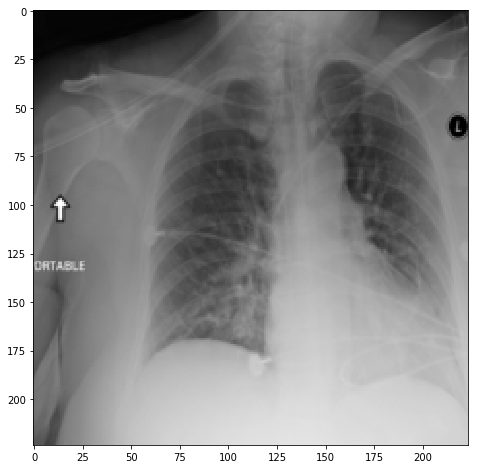

In [101]:
index = 2009
img = test_X[index]
print(torch.sum(img > 0))
print(img)
print(type(img))
to_plot = img.cpu().numpy() #+ mean_image
print(to_plot.shape)
plt.imshow(to_plot[0])
plt.show()

In [78]:
print(type(csv_test))
print(len(test_X))

<class 'pandas.core.frame.DataFrame'>
12386


In [79]:
try:
    del csv_test['age']
except KeyError as e:
    print(e)
try:
    del csv_test['gender']
except KeyError as e:
    print(e)
try:
    del csv_test['view_position']
except KeyError as e:
    print(e)
try:
    del csv_test['image_name']
except KeyError as e:
    print(e)
try:
    del csv_test['detected']
except KeyError as e:
    print(e)

print(list(csv_test))

'age'
'gender'
'view_position'
'image_name'
'detected'
['row_id']


In [102]:
inputs = test_X[0]
print(inputs.unsqueeze(0).size())
test = torch.cat((inputs.unsqueeze(0), inputs.unsqueeze(0)), 0)
print(test.size())
#if model.is_cuda:
#        inputs = inputs.cuda()
outputs = model(Variable(test))
_, preds = torch.max(outputs, 1)
print(preds)

torch.Size([1, 3, 224, 224])
torch.Size([2, 3, 224, 224])
Variable containing:
 8
 5
[torch.LongTensor of size 2]



## Prediction and Submission CSV

In [119]:
import pandas as pd
index = 0
jump = 30
detected = []
pred_set = set()
debug_length = 10
for i in tqdm(range(len(test_X))):
#for i in tqdm(range(debug_length)):
    #start = index
    #end = index + jump
    #if end >= (test_X.size()[0]) :
    #    end = test_X.size()[0]
    inputs = test_X[i]
    inputs = Variable(inputs.unsqueeze(0))
    #print(inputs.data.size())
    # if model.is_cuda:
    #     inputs = inputs.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    ###
    int_list_preds = preds.data.cpu().numpy().tolist()
    for pred_num in int_list_preds:
        pred_set.add(pred_num + 1)
    str_list_preds = [('class_' + str(pred_num + 1)) for pred_num in int_list_preds]
    detected.extend(str_list_preds)
    ####
    #if end == test_X.size()[0]:
    #    break
    #index += jump


  1%|          | 144/12386 [01:14<1:45:30,  1.93it/s]


  1%|▏         | 167/12386 [01:26<1:45:15,  1.93it/s]


KeyboardInterrupt: 

In [109]:
print(pred_set)
csv_test['detected'] = pd.Series(detected)
csv_test.to_csv('submission.csv', index=False)
print(csv_test)

{1, 3, 5, 7, 9, 10, 12}
         row_id  detected
0        id_100   class_3
1      id_10002  class_10
2      id_10005   class_9
3      id_10008  class_12
4      id_10009   class_9
5      id_10013  class_10
6      id_10015   class_5
7      id_10017   class_1
8      id_10018   class_1
9      id_10020   class_7
10     id_10023       NaN
11     id_10024       NaN
12     id_10027       NaN
13     id_10028       NaN
14     id_10029       NaN
15     id_10030       NaN
16     id_10031       NaN
17     id_10033       NaN
18     id_10035       NaN
19     id_10037       NaN
20     id_10048       NaN
21     id_10050       NaN
22     id_10052       NaN
23     id_10054       NaN
24     id_10056       NaN
25     id_10057       NaN
26     id_10060       NaN
27     id_10061       NaN
28     id_10063       NaN
29     id_10068       NaN
...         ...       ...
12356   id_9943       NaN
12357   id_9947       NaN
12358   id_9948       NaN
12359    id_995       NaN
12360   id_9950       NaN
12361   id_995

model.save("models/classification_cnn.model")